# File for exploring data

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import os
import random

In [ ]:
def load_speech_data(congress_number):
    """
    Load speech data for a given congress number with enhanced error handling.
    """
    try:
        # Load the speech texts
        speeches_file = f'../small_speech_data/speeches_{congress_number}_trimmed.txt'
        speech_df = pd.read_csv(
            speeches_file, 
            delimiter='|', 
            names=['speech_id', 'speech_text'], 
            dtype={'speech_id': str, 'speech_text': str},
            skiprows=1
        )
        
        # Load the corresponding description file
        desc_file = f'../small_speech_data/descr_{congress_number}.txt'
        
        # Read the column names from the first line
        with open(desc_file, 'r') as f:
            header = f.readline().strip().split('|')
        
        # Read the description file
        desc_df = pd.read_csv(
            desc_file,
            delimiter='|',
            names=header,
            dtype={
                'speech_id': str,
                'chamber': str,
                'date': str,
                'number_within_file': str,
                'speaker': str,
                'first_name': str,
                'last_name': str,
                'state': str,
                'gender': str,
                'line_start': str,
                'line_end': str,
                'file': str,
                'char_count': str,
                'word_count': str
            },
            skiprows=1
        )
        
        # Convert numeric columns after loading
        desc_df['char_count'] = pd.to_numeric(desc_df['char_count'], errors='coerce')
        desc_df['word_count'] = pd.to_numeric(desc_df['word_count'], errors='coerce')
        desc_df['number_within_file'] = pd.to_numeric(desc_df['number_within_file'], errors='coerce')
        
        print(f"\nCongress {congress_number} data summary:")
        print(f"Number of speeches: {len(speech_df)}")
        print(f"Number of descriptions: {len(desc_df)}")
        
        # Verify data types before merge
        print("\nData types in speech_df:")
        print(speech_df.dtypes)
        print("\nData types in desc_df:")
        print(desc_df.dtypes)
        
        # Check for any null speech_ids
        print("\nChecking for null speech_ids:")
        print(f"Null speech_ids in speech_df: {speech_df['speech_id'].isnull().sum()}")
        print(f"Null speech_ids in desc_df: {desc_df['speech_id'].isnull().sum()}")
        
        # Check for duplicate speech_ids
        print("\nChecking for duplicate speech_ids:")
        print(f"Duplicate speech_ids in speech_df: {speech_df['speech_id'].duplicated().sum()}")
        print(f"Duplicate speech_ids in desc_df: {desc_df['speech_id'].duplicated().sum()}")
        
        # Merge the dataframes
        merged_df = pd.merge(speech_df, desc_df, on='speech_id', how='inner')
        print(f"\nNumber of speeches after merge: {len(merged_df)}")
        
        try:
            # Try to add party information
            merged_df = add_party_information(merged_df, congress_number)
        except Exception as e:
            print(f"\nWarning: Could not add party information: {e}")
            print("Proceeding without party information")
        
        return merged_df
    
    except Exception as e:
        print(f"Error processing congress {congress_number}")
        print(f"Full error: {str(e)}")
        return None

In [4]:
def add_party_information(df, congress_number):
    """
    Add party information using SpeakerMap files with enhanced error handling
    """
    try:
        speaker_map_file = f'../small_speech_data/{congress_number}_SpeakerMap.txt'
        
        print(f"\nAttempting to load SpeakerMap file: {speaker_map_file}")
        
        # First check if file exists
        if not os.path.exists(speaker_map_file):
            print(f"Warning: SpeakerMap file not found: {speaker_map_file}")
            return df
        
        # Read the header first
        with open(speaker_map_file, 'r') as f:
            header = f.readline().strip().split('|')
            print(f"SpeakerMap headers: {header}")
        
        # Read the SpeakerMap file
        speaker_df = pd.read_csv(
            speaker_map_file,
            delimiter='|',
            names=header,
            dtype=str,  # Read all columns as strings initially
            skiprows=1
        )
        
        print(f"Loaded SpeakerMap data: {len(speaker_df)} rows")
        
        if 'speech_id' not in speaker_df.columns:
            print("Warning: No speech_id column in SpeakerMap file")
            return df
            
        if 'party' not in speaker_df.columns:
            print("Warning: No party column in SpeakerMap file")
            return df
        
        # Merge party information
        df = pd.merge(
            df,
            speaker_df[['speech_id', 'party']],
            on='speech_id',
            how='left'
        )
        
        print("\nParty information summary:")
        print(df['party'].value_counts(dropna=False))
        
        return df
        
    except Exception as e:
        print(f"Error in add_party_information: {str(e)}")
        print("Proceeding without party information")
        return df

In [17]:
def analyze_speech_lengths(df):
    """
    Analyze the distribution of speech lengths.
    """
    df['word_count'] = df['speech_text'].str.split().str.len()
    
    stats = {
        'mean_length': df['word_count'].mean(),
        'median_length': df['word_count'].median(),
        'std_length': df['word_count'].std(),
        'min_length': df['word_count'].min(),
        'max_length': df['word_count'].max(),
        'quartiles': df['word_count'].quantile([0.25, 0.5, 0.75]).to_dict()
    }

    # create a dict that for every range of 50 words, counts the number of speeches in that range
    # so like, how many speeches have between 0 and 50 words, how many have between 51 and 100 words, etc.
    word_count_ranges = defaultdict(int)
    for word_count in df['word_count']:
        word_count_ranges[word_count // 50] += 1
    # print how many are between 0 and 50, 51 and 1000, 101 to 150, 151 to 200, 201 to 250, 251 to 300, 301 to 350, 251 to 400
    print("Word count ranges:")
    for i in range(0, 400, 50):
        print(f"{i}-{i+50}: {word_count_ranges[i // 50]}")
    
    # Plot length distribution with log scale
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df['word_count'], bins=50)
    plt.title('Distribution of Speech Lengths')
    plt.xlabel('Number of Words')
    plt.ylabel('Count')
    plt.yscale('log')  # Using log scale for better visualization
    plt.show()
    
    return stats

In [6]:
def clean_topic_file(filename):
    """
    Clean a topic file by fixing malformed lines and returning clean data
    """
    clean_lines = []
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
            for i, line in enumerate(lines, 1):
                line = line.strip()
                if not line:  # Skip empty lines
                    continue
                    
                # Split on pipe
                parts = line.split('|')
                
                if len(parts) == 2:
                    # Line is good, add it as is
                    clean_lines.append(line)
                elif len(parts) > 2:
                    # Try to fix malformed line
                    # Look for pattern: topic|phrase|topic|phrase
                    if len(parts) == 4 and parts[0] and parts[2]:
                        # Split into two lines
                        clean_lines.append(f"{parts[0]}|{parts[1]}")
                        clean_lines.append(f"{parts[2]}|{parts[3]}")
                    else:
                        print(f"Warning: Skipping malformed line {i}: {line}")
                else:
                    print(f"Warning: Skipping invalid line {i}: {line}")
        
        # Write cleaned data to temporary file
        temp_filename = f"cleaned_{os.path.basename(filename)}"
        with open(temp_filename, 'w', encoding='utf-8') as f:
            for line in clean_lines:
                f.write(line + '\n')
        
        return temp_filename
    
    except Exception as e:
        print(f"Error cleaning file {filename}: {e}")
        return None

In [7]:
def load_topic_files():
    """
    Load and validate topic-related files
    """
    try:
        # Clean files first
        files_to_clean = {
            'topic_phrases': '../phrase_clusters/topic_phrases.txt',
            'keywords': '../phrase_clusters/keywords.txt',
            'false_matches': '../phrase_clusters/false_matches.txt'
        }
        
        cleaned_files = {}
        for key, filepath in files_to_clean.items():
            cleaned_filepath = clean_topic_file(filepath)
            if cleaned_filepath is None:
                return None
            cleaned_files[key] = cleaned_filepath
        
        # Load cleaned files
        topic_phrases = pd.read_csv(
            cleaned_files['topic_phrases'],
            delimiter='|',
            names=['topic', 'phrase'],
            dtype={'topic': str, 'phrase': str}
        )
        
        keywords = pd.read_csv(
            cleaned_files['keywords'],
            delimiter='|',
            names=['topic', 'phrase'],
            dtype={'topic': str, 'phrase': str}
        )
        
        false_matches = pd.read_csv(
            cleaned_files['false_matches'],
            delimiter='|',
            names=['topic', 'phrase'],
            dtype={'topic': str, 'phrase': str}
        )
        
        # Clean up temporary files
        for filepath in cleaned_files.values():
            try:
                os.remove(filepath)
            except:
                pass
        
        # Topic thresholds from codebook
        topic_thresholds = {
            'alcohol': 50, 'budget': 125, 'business': 75,
            'crime': 50, 'defense': 75, 'economy': 50,
            'education': 50, 'elections': 50, 'environment': 50,
            'federalism': 125, 'foreign': 125, 'government': 75,
            'health': 50, 'immigration': 50, 'justice': 50,
            'labor': 75, 'mail': 50, 'minorities': 50,
            'money': 50, 'religion': 50, 'tax': 50, 'trade': 50
        }
        
        # Validate data
        topics = set(topic_thresholds.keys())
        found_topics = set(topic_phrases['topic'].unique())
        
        print("\nTopic Validation:")
        print(f"Expected topics: {len(topics)}")
        print(f"Found topics: {len(found_topics)}")
        print(f"Missing topics: {topics - found_topics}")
        print(f"Extra topics: {found_topics - topics}")
        
        print("\nData Summary:")
        print(f"Topic phrases: {len(topic_phrases)}")
        print(f"Keywords: {len(keywords)}")
        print(f"False matches: {len(false_matches)}")
        
        return {
            'topic_phrases': topic_phrases,
            'keywords': keywords,
            'false_matches': false_matches,
            'thresholds': topic_thresholds,
            'unique_topics': sorted(topic_phrases['topic'].unique())
        }
        
    except Exception as e:
        print(f"Error loading topic files: {e}")
        return None

In [8]:
def analyze_speech_topics(speech_text, topic_data):
    """
    Analyze topics in a speech with occurrence-based thresholds.
    """
    # Convert to lowercase and clean text
    text = speech_text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = ' '.join(text.split())
    
    # Initialize results
    topics_found = defaultdict(lambda: {'count': 0, 'evidence': []})
    debug_info = {
        'keywords_checked': 0,
        'keywords_found': 0,
        'phrases_checked': 0,
        'phrases_found': 0,
        'false_matches': 0
    }
    
    # Check keywords
    for _, row in topic_data['keywords'].iterrows():
        keyword = row['phrase'].lower()
        topic = row['topic']
        debug_info['keywords_checked'] += 1
        
        if f" {keyword} " in f" {text} ":
            # Check if it's a false match
            is_false = any(
                f" {fm.lower()} " in f" {text} "
                for fm in topic_data['false_matches'][
                    topic_data['false_matches']['topic'] == topic
                ]['phrase']
            )
            
            if is_false:
                debug_info['false_matches'] += 1
            else:
                debug_info['keywords_found'] += 1
                topics_found[topic]['count'] += 1
                topics_found[topic]['evidence'].append(f"Keyword: {keyword}")
    
    # Check phrases
    for _, row in topic_data['topic_phrases'].iterrows():
        phrase = row['phrase'].lower()
        topic = row['topic']
        debug_info['phrases_checked'] += 1
        
        if f" {phrase} " in f" {text} ":
            debug_info['phrases_found'] += 1
            topics_found[topic]['count'] += 1
            topics_found[topic]['evidence'].append(f"Phrase: {phrase}")
    
    # Prepare results without applying a minimum threshold
    results = {}
    for topic, data in topics_found.items():
        if data['count'] > 0:  # Include all topics with at least one match
            results[topic] = data
    
    # Periodically print debug information
    if random.random() < 0.01:  # Print for ~1% of speeches
        print("\nTopic Analysis Debug Info:")
        print(f"Text length: {len(text.split())} words")
        print(f"Keywords checked: {debug_info['keywords_checked']}")
        print(f"Keywords found: {debug_info['keywords_found']}")
        print(f"Phrases checked: {debug_info['phrases_checked']}")
        print(f"Phrases found: {debug_info['phrases_found']}")
        print(f"False matches: {debug_info['false_matches']}")
        print(f"Topics found: {len(results)}")
    
    return results

In [9]:
def analyze_topics_over_time(df, topic_data):
    """
    Analyze how topics change over time with detailed debugging
    """
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['month'] = df['date'].dt.to_period('M')
    
    topic_time_series = defaultdict(lambda: defaultdict(int))
    
    # Add debug counters
    total_processed = 0
    speeches_with_topics = 0
    topic_counts = defaultdict(int)
    
    print("\nStarting topic analysis over time...")
    print("Sample of keywords:", list(topic_data['keywords']['phrase'])[:5])
    print("Sample of topic phrases:", list(topic_data['topic_phrases']['phrase'])[:5])
    
    # Process speeches
    for idx, row in df.iterrows():
        if idx > 2000:  # Limit for testing
            break
            
        if idx % 100 == 0:  # Progress indicator
            print(f"Processing speech {idx}/2000")
            print(f"Found topics in {speeches_with_topics}/{total_processed} speeches")
            print("Current topic counts:", dict(topic_counts))
        
        total_processed += 1
        topics = analyze_speech_topics(row['speech_text'], topic_data)
        
        if topics:
            speeches_with_topics += 1
            month = row['month']
            for topic in topics:
                topic_time_series[topic][month] += 1
                topic_counts[topic] += 1
                
        # Debug: Print sample of speeches without topics periodically
        if idx % 1000 == 0 and not topics:
            print("\nExample of speech without topics:")
            print("Speech text excerpt:", row['speech_text'][:200])
            print("Speech length:", len(row['speech_text'].split()))
    
    # Print final statistics
    print("\nTopic Analysis Summary:")
    print(f"Total speeches processed: {total_processed}")
    print(f"Speeches with topics: {speeches_with_topics}")
    print(f"Detection rate: {(speeches_with_topics/total_processed)*100:.2f}%")
    print("\nTopic frequencies:")
    for topic, count in topic_counts.items():
        print(f"{topic}: {count}")
    
    # Convert to DataFrame
    time_series_df = pd.DataFrame(topic_time_series)
    
    # Debug: Print shape and sample of DataFrame
    print("\nTime series DataFrame shape:", time_series_df.shape)
    print("Time series columns:", time_series_df.columns.tolist())
    print("\nSample of time series data:")
    print(time_series_df.head())
    
    # Plot only if we have data
    if not time_series_df.empty:
        plt.figure(figsize=(15, 8))
        for topic in time_series_df.columns:
            plt.plot(range(len(time_series_df)), time_series_df[topic], label=topic)
        
        plt.title('Topic Frequency Over Time')
        plt.xlabel('Months')
        plt.ylabel('Number of Speeches')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("\nWarning: No topic data to plot")
    
    return time_series_df

In [10]:
def analyze_party_topic_distribution(df, topic_data):
    """
    Analyze topic distribution across parties
    """
    if 'party' not in df.columns:
        print("Warning: No party information available")
        return None
    
    party_topic_counts = defaultdict(lambda: defaultdict(int))
    
    # Process each speech
    for idx, row in df.iterrows():
        # break at 2000
        if idx == 2000:
            break
        if idx % 1000 == 0:
            print(f"Processing speech {idx}/2000")
            
        topics = analyze_speech_topics(row['speech_text'], topic_data)
        party = row['party']
        
        for topic in topics:
            party_topic_counts[party][topic] += 1
    
    # Convert to DataFrame
    party_topic_df = pd.DataFrame(party_topic_counts)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(party_topic_df, annot=True, fmt='g', cmap='YlOrRd')
    plt.title('Topic Distribution Across Parties')
    plt.tight_layout()
    plt.show()
    
    return party_topic_df

In [11]:
def save_speech_topic_mapping(df, topic_data, output_file='speech_topic_mapping.csv'):
    """
    Map each speech ID to detected topics and save as a CSV file.
    """
    mapping = []

    print("\nMapping topics to speeches...")
    for idx, row in df.iterrows():
        # break at 2000
        if idx == 2000:
            break
        topics = analyze_speech_topics(row['speech_text'], topic_data)
        topics_list = list(topics.keys()) if topics else []
        mapping.append({
            'speech_id': row['speech_id'],
            'topics': ', '.join(topics_list) if topics_list else 'None'
        })
        if idx % 1000 == 0:  # Progress indicator
            print(f"Processed {idx}/2000 speeches...")

    # Convert mapping to DataFrame
    topic_mapping_df = pd.DataFrame(mapping)

    # Save to CSV
    topic_mapping_df.to_csv(output_file, index=False)
    print(f"Speech-to-topic mapping saved to {output_file}")

In [18]:
def main():
    # Load data for multiple congresses
    congress_numbers = ['113', '114']
    all_data = []
    
    for congress in congress_numbers:
        print(f"\nProcessing Congress {congress}")
        df = load_speech_data(congress)
        if df is not None:
            print(f"Successfully loaded Congress {congress} data")
            all_data.append(df)
    
    if not all_data:
        print("\nNo data was successfully loaded.")
        return
    
    # Combine the data
    print("\nCombining data from all congresses...")
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Proceed with the rest of your analyses
    print("\nDataset Overview:")
    print(f"Total number of speeches: {len(combined_df)}")
    print("\nColumns available:", combined_df.columns.tolist())
    print("\nMissing values:\n", combined_df.isnull().sum())
    
    # Speech length analysis
    print("\nSpeech Length Analysis:")
    length_stats = analyze_speech_lengths(combined_df)
    print("Length statistics:")
    for key, value in length_stats.items():
        print(f"{key}: {value}")
    
    # Sample of different length speeches
    print("\nSample of shortest speeches:")
    print(combined_df.nsmallest(3, 'word_count')[['speech_text', 'word_count', 'party']])
    
    print("\nSample of median-length speeches:")
    median_length = combined_df['word_count'].median()
    median_speeches = combined_df.iloc[(combined_df['word_count'] - median_length).abs().argsort()[:3]]
    print(median_speeches[['speech_text', 'word_count', 'party']])
    
    # Topic analysis
    print("\nLoading and analyzing topics...")
    topic_data = load_topic_files()
    
    if topic_data is not None:
        # Analyze sample of speeches for topics
        print("\nAnalyzing topics in sample speeches:")
        sample_size = 5
        sample_speeches = combined_df.sample(n=sample_size, random_state=42)
        
        for _, speech in sample_speeches.iterrows():
            print(f"\nSpeech ID: {speech['speech_id']}")
            print(f"Party: {speech.get('party', 'Unknown')}")
            print(f"Word count: {speech['word_count']}")
            print("Excerpt:", speech['speech_text'][:200], "...")
            
            topics = analyze_speech_topics(speech['speech_text'], topic_data)
            if topics:
                print("Topics found:")
                for topic, details in topics.items():
                    print(f"- {topic}: {details['count']} matches")
                    print(f"  Evidence: {', '.join(details['evidence'][:3])}")
            else:
                print("No topics met the threshold criteria")
        
        # Temporal analysis of topics
        print("\nAnalyzing topic trends over time...")
        time_series_df = analyze_topics_over_time(combined_df, topic_data)

        print("\nSaving speech-to-topic mapping...")
        save_speech_topic_mapping(combined_df, topic_data, output_file='speech_topic_mapping.csv')
        
        # Save time series data
        time_series_df.to_csv('topic_time_series.csv')
        print("Time series data saved to topic_time_series.csv")
        
        # Party-topic distribution
        print("\nAnalyzing topic distribution across parties...")
        party_topic_df = analyze_party_topic_distribution(combined_df, topic_data)
        
        if party_topic_df is not None:
            # Save party-topic distribution
            party_topic_df.to_csv('party_topic_distribution.csv')
            print("Party-topic distribution saved to party_topic_distribution.csv")
            
            # Print summary statistics
            print("\nTop topics by party:")
            for party in party_topic_df.columns:
                top_topics = party_topic_df[party].nlargest(3)
                print(f"\n{party}:")
                for topic, count in top_topics.items():
                    print(f"- {topic}: {count} speeches")
    
    # Additional temporal analysis
    print("\nAnalyzing speech patterns over time...")
    combined_df['date'] = pd.to_datetime(combined_df['date'], format='%Y%m%d')
    combined_df['month'] = combined_df['date'].dt.to_period('M')
    
    # Monthly speech counts
    monthly_counts = combined_df.groupby('month').size()
    
    plt.figure(figsize=(15, 6))
    monthly_counts.plot(kind='line')
    plt.title('Number of Speeches per Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Speeches')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Average speech length over time
    monthly_lengths = combined_df.groupby('month')['word_count'].mean()
    
    plt.figure(figsize=(15, 6))
    monthly_lengths.plot(kind='line')
    plt.title('Average Speech Length over Time')
    plt.xlabel('Month')
    plt.ylabel('Average Word Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save processed data
    print("\nSaving processed data...")
    
    # Save basic statistics
    stats_summary = {
        'total_speeches': len(combined_df),
        'unique_speakers': combined_df['speaker'].nunique(),
        'date_range': f"{combined_df['date'].min()} to {combined_df['date'].max()}",
        'length_stats': length_stats,
    }
    
    if party_stats is not None:
        stats_summary['party_distribution'] = party_stats.to_dict()
    
    # Convert to DataFrame for easy CSV export
    stats_df = pd.DataFrame([stats_summary])
    stats_df.to_csv('speech_analysis_summary.csv')
    print("Analysis summary saved to speech_analysis_summary.csv")
    
    # Save sample of speeches with their topics
    if topic_data is not None:
        print("\nSaving sample speeches with topic analysis...")
        sample_size = min(1000, len(combined_df))
        sample_with_topics = combined_df.sample(n=sample_size, random_state=42)
        
        topic_results = []
        for _, speech in sample_with_topics.iterrows():
            topics = analyze_speech_topics(speech['speech_text'], topic_data)
            result = {
                'speech_id': speech['speech_id'],
                'party': speech.get('party', 'Unknown'),
                'date': speech['date'],
                'word_count': speech['word_count'],
                'topics_found': ','.join(topics.keys()) if topics else 'None'
            }
            topic_results.append(result)
        
        topic_analysis_df = pd.DataFrame(topic_results)
        topic_analysis_df.to_csv('speech_topic_samples.csv', index=False)
        print("Sample speeches with topics saved to speech_topic_samples.csv")
    
    print("\nAnalysis complete!")


Processing Congress 113

Congress 113 data summary:
Number of speeches: 12813
Number of descriptions: 128148

Data types in speech_df:
speech_id      object
speech_text    object
dtype: object

Data types in desc_df:
speech_id             object
chamber               object
date                  object
number_within_file     int64
speaker               object
first_name            object
last_name             object
state                 object
gender                object
line_start            object
line_end              object
file                  object
char_count             int64
word_count             int64
dtype: object

Checking for null speech_ids:
Null speech_ids in speech_df: 0
Null speech_ids in desc_df: 0

Checking for duplicate speech_ids:
Duplicate speech_ids in speech_df: 0
Duplicate speech_ids in desc_df: 0

Number of speeches after merge: 12813

Attempting to load SpeakerMap file: ../small_speech_data/113_SpeakerMap.txt
SpeakerMap headers: ['speakerid', 'speech_id'

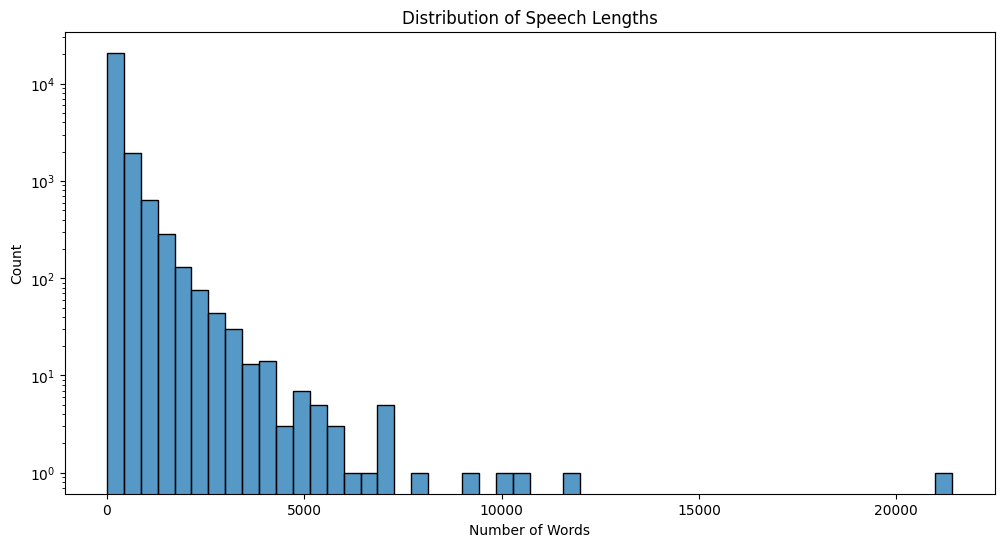

Length statistics:
mean_length: 201.82821014100912
median_length: 30.0
std_length: 461.9561056333619
min_length: 1
max_length: 21422
quartiles: {0.25: 10.0, 0.5: 30.0, 0.75: 219.0}

Sample of shortest speeches:
          speech_text  word_count party
26   Congratulations.           1   NaN
143          Maryland           1     D
145             Texas           1   NaN

Sample of median-length speeches:
                                            speech_text  word_count party
4560  Pursuant to clause 12(a) of rule I. the Chair ...          30   NaN
5991  Pursuant to clause 12(a) of rule I. the Chair ...          30   NaN
4828  I appreciate the question from the Senator fro...          30     R

Loading and analyzing topics...

Topic Validation:
Expected topics: 22
Found topics: 23
Missing topics: set()
Extra topics: {'topic'}

Data Summary:
Topic phrases: 7556
Keywords: 297
False matches: 3009

Analyzing topics in sample speeches:

Speech ID: 1140004827
Party: R
Word count: 148
Excerpt:

KeyboardInterrupt: 

In [19]:
if __name__ == "__main__":
    main()